<a href="https://colab.research.google.com/github/eunShim/BigDataCapstone/blob/main/bigdatacapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# ==========================================
# EdNet-KT3: 500명 샘플 추출 → 사용자 특징 → K-means → 군집 의미 라벨링 + 시각화
# 요구 컬럼: ['timestamp','action_type','item_id','source','user_answer','platform']
# df는 개별 유저 csv를 읽어 만듭니다 (ZIP 내부: KT3/uXXXX.csv, 한 파일=한 사용자)
# ==========================================
import zipfile
import random
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ---------- 설정 ----------
zip_path = "/content/EdNet-KT3.zip"   # Colab 로컬(/content)로 복사해 놓는 것을 권장
RANDOM_SEED = 42
N_USERS = 500
N_CLUSTERS = 3

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ---------- 1) ZIP에서 사용자 500명 샘플 ----------
with zipfile.ZipFile(zip_path, 'r') as z:
    user_files = [f for f in z.namelist() if f.startswith("KT3/") and f.endswith(".csv")]
    if len(user_files) == 0:
        raise RuntimeError("ZIP 안에서 'KT3/*.csv' 파일을 찾지 못했습니다.")
    k = min(N_USERS, len(user_files))
    sample_files = random.sample(user_files, k)
    print(f"[INFO] 전체 사용자 파일수={len(user_files)} / 샘플링={k}")

# ---------- 2) 샘플 사용자들의 로그 읽고 특징 뽑기 ----------
def features_from_user_csv(file_in_zip: str) -> dict:
    """한 사용자 파일에서 특징 추출:
       - total_attempts: submit(문제 풀이 완료) 개수
       - avg_elapsed  : enter~submit 소요시간(초)의 item별 평균
       - answer_rate  : submit 중 user_answer가 NaN이 아닌 비율
       소요시간은 (같은 item_id 내) 'enter' 최초 시각과 'submit' 최초 시각 차이로 계산.
    """
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(file_in_zip) as fp:
            dfu = pd.read_csv(fp, low_memory=False)

    # 필수 컬럼 체크
    needed = {"timestamp","action_type","item_id","user_answer"}
    if not needed.issubset(set(dfu.columns)):
        raise ValueError(f"{file_in_zip}에 필요한 컬럼({needed})이 없습니다. 실제 컬럼: {dfu.columns.tolist()}")

    # 타입/정렬
    dfu["timestamp"] = pd.to_datetime(dfu["timestamp"], errors="coerce")
    dfu = dfu.dropna(subset=["timestamp"]).sort_values(["item_id","timestamp"])

    # 시도(=submit) 개수
    submits = dfu[dfu["action_type"] == "submit"]
    total_attempts = int(len(submits))

    # 응답률: submit 중 user_answer 결측이 아닌 비율
    answer_rate = float(submits["user_answer"].notna().mean()) if total_attempts > 0 else 0.0

    # item_id별 소요시간: enter 최초 vs submit 최초
    # (enter가 있고 submit도 있는 item만 사용)
    enters = dfu[dfu["action_type"] == "enter"].groupby("item_id")["timestamp"].first()
    subts  = submits.groupby("item_id")["timestamp"].first()
    joined = pd.DataFrame({"t_enter": enters, "t_submit": subts}).dropna()
    # 양수 시간만
    elapsed = (joined["t_submit"] - joined["t_enter"]).dt.total_seconds()
    elapsed = elapsed[elapsed > 0]
    avg_elapsed = float(elapsed.mean()) if len(elapsed) else 0.0

    return {
        "source_file": file_in_zip.split("/")[-1].replace(".csv",""),
        "total_attempts": total_attempts,
        "avg_elapsed": avg_elapsed,
        "answer_rate": answer_rate
    }

# 병렬이 필요하면 multiprocessing 가능하지만, 먼저 단일 루프:
user_rows = []
for f in sample_files:
    try:
        user_rows.append(features_from_user_csv(f))
    except Exception as e:
        # 문제 있는 파일은 스킵
        print(f"[WARN] {f} 처리 중 에러, 스킵: {e}")

user_stats = pd.DataFrame(user_rows)
if user_stats.empty:
    raise RuntimeError("특징이 추출된 사용자가 없습니다.")

# 결측/무한 보정
user_stats = user_stats.replace([np.inf,-np.inf], np.nan).fillna(0)

print("\n[HEAD] 사용자 특징 예시:")
print(user_stats.head())



[INFO] 전체 사용자 파일수=297915 / 샘플링=500

[HEAD] 사용자 특징 예시:
  source_file  total_attempts  avg_elapsed  answer_rate
0     u598638             409     0.000035          0.0
1     u590300              19     0.000022          0.0
2     u637607               8     0.000021          0.0
3     u287913              17     0.000013          0.0
4     u319733               6     0.000033          0.0


In [41]:
# ---------- 3) K-means 군집화 ----------
feat_cols = ["total_attempts","avg_elapsed","answer_rate"]
X = user_stats[feat_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED, n_init="auto")
labels = kmeans.fit_predict(X_scaled)
user_stats["cluster"] = labels

# 평가(옵션)
try:
    sil = silhouette_score(X_scaled, labels)
    print(f"\n[INFO] Silhouette score (higher better): {sil:.3f}")
except Exception:
    pass

# ---------- 4) 군집 의미(센트로이드) 해석 ----------
# 센트로이드를 원래 스케일로 되돌려서 해석
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
cent_df = pd.DataFrame(centers, columns=feat_cols)
cent_df["cluster"] = range(N_CLUSTERS)

# 각 변수의 분위수로 High/Med/Low 범주화하여 설명 문자열 생성
q = user_stats[feat_cols].quantile([0.33, 0.67])
def levelize(val, col):
    if val <= q.loc[0.33, col]: return "Low"
    if val >= q.loc[0.67, col]: return "High"
    return "Med"

def speed_word(val):  # avg_elapsed는 낮을수록 빠름 → Fast/Medium/Slow
    if val <= q.loc[0.33, "avg_elapsed"]: return "Fast"
    if val >= q.loc[0.67, "avg_elapsed"]: return "Slow"
    return "Medium"

interpretations = []
for i, row in cent_df.sort_values("cluster").iterrows():
    attempts_tag = levelize(row["total_attempts"], "total_attempts")
    elapsed_tag  = speed_word(row["avg_elapsed"])
    answer_tag   = levelize(row["answer_rate"], "answer_rate").replace("Med","Mid")
    label = f"{attempts_tag}-attempts / {elapsed_tag}-speed / {answer_tag}-answer-rate"
    interpretations.append((int(row["cluster"]), label))
interp_map = dict(interpretations)

# 라벨 컬럼 추가
user_stats["cluster_label"] = user_stats["cluster"].map(interp_map)

print("\n[군집 센트로이드(원단위) & 라벨]")
out = cent_df.copy()
out["label"] = out["cluster"].map(interp_map)
print(out[["cluster","total_attempts","avg_elapsed","answer_rate","label"]].round(3))

print("\n[클러스터 분포]")
print(user_stats["cluster_label"].value_counts())




[INFO] Silhouette score (higher better): 0.666

[군집 센트로이드(원단위) & 라벨]
   cluster  total_attempts  avg_elapsed  answer_rate  \
0        0         787.867          0.0          0.0   
1        1          44.660          0.0          0.0   
2        2          22.021          0.0          0.0   

                                            label  
0    High-attempts / Slow-speed / Low-answer-rate  
1    High-attempts / Slow-speed / Low-answer-rate  
2  High-attempts / Medium-speed / Low-answer-rate  

[클러스터 분포]
cluster_label
High-attempts / Medium-speed / Low-answer-rate    435
High-attempts / Slow-speed / Low-answer-rate       65
Name: count, dtype: int64


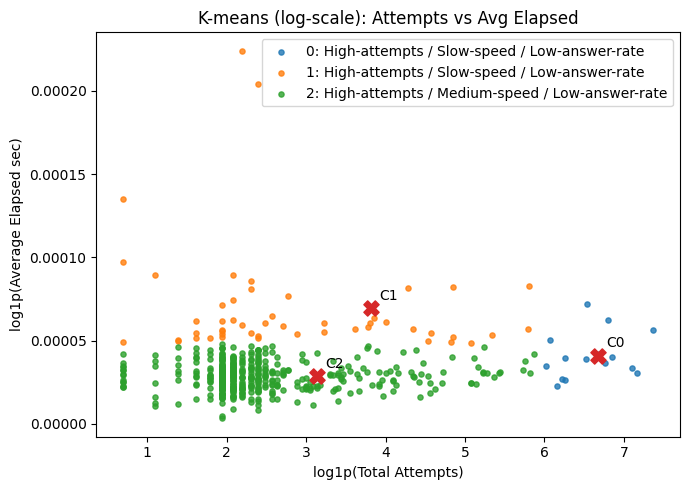

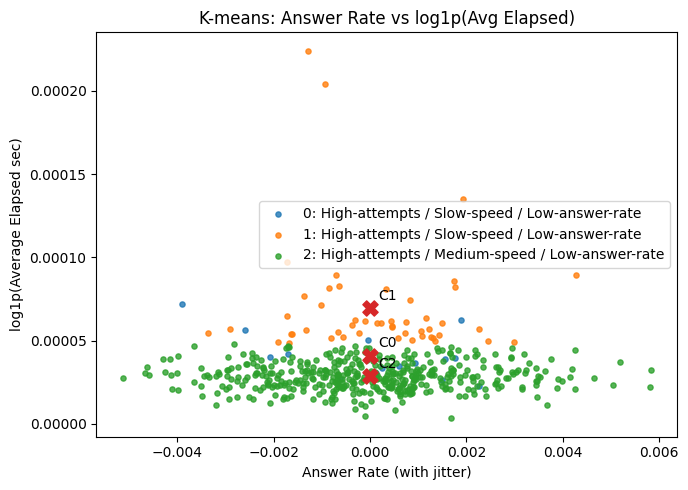

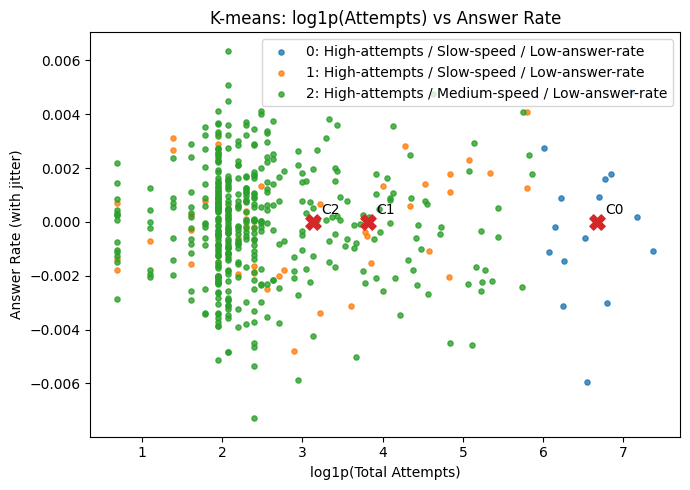

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 5) 시각화 (Matplotlib만, 색 지정 X) ----------
# 유틸: log1p 변환 (0 허용), 약간의 지터로 포인트 겹침 완화
_rng = np.random.default_rng(42)
_eps = 1e-9

def _log1p_safe(a):
    return np.log1p(np.maximum(np.asarray(a), 0))

def _jitter(a, scale):
    a = np.asarray(a, dtype=float)
    return a + _rng.normal(0.0, scale, size=a.shape)

# (1) Attempts vs Avg Elapsed  — 둘 다 log1p, 센트로이드(X) 및 주석 표시
plt.figure(figsize=(7,5))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    x = _log1p_safe(part["total_attempts"].values)
    y = _log1p_safe(part["avg_elapsed"].values + _eps)
    plt.scatter(x, y, label=f"{c}: {user_stats.loc[user_stats['cluster']==c,'cluster_label'].iloc[0]}", s=14, alpha=0.8)

# 센트로이드(원 단위 → log1p 좌표로 변환)
cx = _log1p_safe(cent_df.sort_values("cluster")["total_attempts"].values)
cy = _log1p_safe(cent_df.sort_values("cluster")["avg_elapsed"].values + _eps)
plt.scatter(cx, cy, marker="X", s=120)
for i, (px, py) in enumerate(zip(cx, cy)):
    plt.annotate(f"C{i}", (px, py), xytext=(6,6), textcoords="offset points")

plt.title("K-means (log-scale): Attempts vs Avg Elapsed")
plt.xlabel("log1p(Total Attempts)")
plt.ylabel("log1p(Average Elapsed sec)")
plt.legend()
plt.tight_layout()
plt.show()

# (2) Answer Rate vs Avg Elapsed — answer_rate가 0에 몰려 있으니 x축에 지터 추가, y는 log1p
plt.figure(figsize=(7,5))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    x = _jitter(part["answer_rate"].values, scale=0.002)  # 좌우로 살짝 흩뿌리기
    y = _log1p_safe(part["avg_elapsed"].values + _eps)
    plt.scatter(x, y, label=f"{c}: {interp_map[c]}", s=14, alpha=0.8)

# 센트로이드
cx = cent_df.sort_values("cluster")["answer_rate"].values
cy = _log1p_safe(cent_df.sort_values("cluster")["avg_elapsed"].values + _eps)
plt.scatter(cx, cy, marker="X", s=120)
for i, (px, py) in enumerate(zip(cx, cy)):
    plt.annotate(f"C{i}", (px, py), xytext=(6,6), textcoords="offset points")

plt.title("K-means: Answer Rate vs log1p(Avg Elapsed)")
plt.xlabel("Answer Rate (with jitter)")
plt.ylabel("log1p(Average Elapsed sec)")
plt.legend()
plt.tight_layout()
plt.show()

# (3) Attempts vs Answer Rate — attempts는 log1p, answer_rate에 세로 지터 추가
plt.figure(figsize=(7,5))
for c in sorted(user_stats["cluster"].unique()):
    part = user_stats[user_stats["cluster"] == c]
    x = _log1p_safe(part["total_attempts"].values)
    y = _jitter(part["answer_rate"].values, scale=0.002)  # 위아래로 살짝 흩뿌리기
    plt.scatter(x, y, label=f"{c}: {interp_map[c]}", s=14, alpha=0.8)

# 센트로이드
cx = _log1p_safe(cent_df.sort_values("cluster")["total_attempts"].values)
cy = cent_df.sort_values("cluster")["answer_rate"].values
plt.scatter(cx, cy, marker="X", s=120)
for i, (px, py) in enumerate(zip(cx, cy)):
    plt.annotate(f"C{i}", (px, py), xytext=(6,6), textcoords="offset points")

plt.title("K-means: log1p(Attempts) vs Answer Rate")
plt.xlabel("log1p(Total Attempts)")
plt.ylabel("Answer Rate (with jitter)")
plt.legend()
plt.tight_layout()
plt.show()
